### Imports and directories

In [1]:
import numpy as np
import os
from oe_acute import trial_utils as tu
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import tqdm
import glob
from scipy.ndimage import gaussian_filter1d
from scipy.stats.stats import pearsonr 

import sys

In [2]:
d=64

In [3]:
exp_path_avgn = '/mnt/cube/srrudrar/avgn_model/B1240/32x32/stim_resp_32x32_{}/test_set_mne/'.format(d)
exp_path_tpm = '/mnt/cube/srrudrar/temporal_model/B1240/32x32/stim_resp_32x32_{}/test_set_mne/'.format(d)
exp_path_tcm = '/mnt/cube/srrudrar/temporal_cnn_model/B1240/32x32/stim_resp_32x32_{}/test_set_mne/'.format(d)
exp_path_tf = '/mnt/cube/srrudrar/transformer_model/B1240/32x32/stim_resp_32x32_{}/test_set_mne/'.format(d)

MNE_test_dset_avgn = '/mnt/cube/srrudrar/avgn_model/B1240/32x32/stim_resp_32x32_{}/test_set_mne/MNE_test_dset/'.format(d)
MNE_test_dset_tpm = '/mnt/cube/srrudrar/temporal_model/B1240/32x32/stim_resp_32x32_{}/test_set_mne/MNE_test_dset/'.format(d) 
MNE_test_dset_tcm = '/mnt/cube/srrudrar/temporal_cnn_model/B1240/32x32/stim_resp_32x32_{}/test_set_mne/MNE_test_dset/'.format(d)
MNE_test_dset_tf = '/mnt/cube/srrudrar/transformer_model/B1240/32x32/stim_resp_32x32_{}/test_set_mne/MNE_test_dset/'.format(d) 

In [4]:
sort_path =  '/mnt/cube/btheilma/sorting/B1240/block3/'
ratings = [1,2,3]
clusters = []
for rating in ratings:
    x = tu.get_clusters_by_rating(sort_path, rating)
    clusters.extend(x)

### Functions

In [5]:
def predict_spiking_response(pfinal, stim_segs, sdim, n_trials=20):

    '''
    Given a pfinal parameter vector and stimulus segments, predict n_trials spike trains
    stim_segs is an array nsegs x ndim
    spikes is a binary array n_trials x nsegs
    TODO: Specify first order or second order model
    '''

    a = pfinal[0]
    h = pfinal[1:sdim+1]
    J = np.reshape(pfinal[-1*sdim**2:], (sdim, sdim))

    x = a + np.dot(stim_segs, h) + np.sum(stim_segs * (stim_segs.dot(J)), 1)
    probs = 1.0 / (1.0 + np.exp(x))
    spikes = np.less(np.random.rand(n_trials, len(probs)), probs).astype(int)
    return spikes

In [6]:
def predict_spiking_probability(pfinal, stim_segs, sdim, **kwargs):

    '''
    Given a pfinal parameter vector and stimulus segments, predict spiking probabilities
    stim_segs is an array nsegs x ndim
    spikes is a binary array n_trials x nsegs
    '''

    a = pfinal[0]
    h = pfinal[1:sdim+1]
    J = np.reshape(pfinal[-1*sdim**2:], (sdim, sdim))
    x = a + np.dot(stim_segs, h) + np.sum(stim_segs * (stim_segs.dot(J)), 1)
    probs = 1.0 / (1.0 + np.exp(x))
    return probs

def predict_spiking_prob_lin(pfinal, stim_segs, sdim, **kwargs):

    '''
    Given a pfinal parameter vector and stimulus segments, predict spiking probabilities
    stim_segs is an array nsegs x ndim
    spikes is a binary array n_trials x nsegs
    '''

    a = pfinal[0]
    h = pfinal[1:sdim+1]
    x = a + np.dot(stim_segs, h)
    probs = 1.0 / (1.0 + np.exp(x))
    return probs

In [7]:
def evaluate_prediction(pfinal, stims_test, resps_test, sdim, **kwargs):
    '''
    Given a vector of MNE parameters pfinal, predict spiking probabilities using stims_test and the 
    MNE model, and compare these to the given 'resps_test' using pearson correlation
    '''
    
    probs = predict_spiking_probability(pfinal, stims_test, sdim, **kwargs)
    corr = pearsonr(probs, resps_test.flatten())
    return probs, corr

def evaluate_pred_lin(pfinal, stims_test, resps_test, sdim, **kwargs):
    '''
    Given a vector of MNE parameters pfinal, predict spiking probabilities using stims_test and the 
    MNE model, and compare these to the given 'resps_test' using pearson correlation
    '''
    
    probs = predict_spiking_prob_lin(pfinal, stims_test, sdim, **kwargs)
    corr = pearsonr(probs, resps_test.flatten())
    return probs, corr

In [8]:
def correlate_gaussian_spiketrains(sp1, sp2, tau):
    '''
    Compute the correlation of two gaussian smoothed spike trains
    sp1, sp2 are lists of spike times, tau is the gaussian standard deviation
    '''
    diffmtx = sp2[:, np.newaxis] - sp1[np.newaxis, :]
    n1 = len(sp1)
    n2 = len(sp2)

    corr = np.sum(np.exp(-0.5*(diffmtx**2 / (2*tau**2)))*(tau*np.sqrt(np.pi)))
    return corr

### Corrs for all units

In [9]:
corrs_full_avgn = []
corrs_full_tpm = []
corrs_full_tcm = []
corrs_full_tf = []
corrs_lin_avgn = []
corrs_lin_tpm = []
corrs_lin_tcm = []
corrs_lin_tf = []
units = []

for unit in clusters:
    ########################### avgn corr
    with open(os.path.join(MNE_test_dset_avgn, 'unit-{}_MNE.pkl'.format(unit)), 'rb') as f:       #change
        test_dict_avgn = pickle.load(f)
    stims_test_avgn = test_dict_avgn['stims_test']
    resps_test_avgn = test_dict_avgn['resps_test']
    
    with open(os.path.join(exp_path_avgn, 'all_1_2_3_MNEs_random_test.pkl'), 'rb') as f:       #change                        
        pfinals_avgn = pickle.load(f)
    pfinal_avgn = pfinals_avgn[unit]
    
    probs_avgn, corr_avgn = evaluate_prediction(pfinal_avgn, stims_test_avgn, resps_test_avgn, sdim=d)
    probs_lin_avgn, corr_lin_avgn = evaluate_pred_lin(pfinal_avgn, stims_test_avgn, resps_test_avgn, sdim=d)
    
    
    ################################ tpm corr
    with open(os.path.join(MNE_test_dset_tpm, 'unit-{}_MNE.pkl'.format(unit)), 'rb') as f:       #change
        test_dict_tpm = pickle.load(f)
    stims_test_tpm = test_dict_tpm['stims_test']
    resps_test_tpm = test_dict_tpm['resps_test']
    
    with open(os.path.join(exp_path_tpm, 'all_1_2_3_MNEs_random_test.pkl'), 'rb') as f:       #change                        
        pfinals_tpm = pickle.load(f)
    pfinal_tpm = pfinals_tpm[unit]
    
    probs_tpm, corr_tpm = evaluate_prediction(pfinal_tpm, stims_test_tpm, resps_test_tpm, sdim=d)
    probs_lin_tpm, corr_lin_tpm = evaluate_pred_lin(pfinal_tpm, stims_test_tpm, resps_test_tpm, sdim=d)
    
    
    ################################# tcm corr
    with open(os.path.join(MNE_test_dset_tcm, 'unit-{}_MNE.pkl'.format(unit)), 'rb') as f:       #change
        test_dict_tcm = pickle.load(f)
    stims_test_tcm = test_dict_tcm['stims_test']
    resps_test_tcm = test_dict_tcm['resps_test']
    
    with open(os.path.join(exp_path_tcm, 'all_1_2_3_MNEs_random_test.pkl'), 'rb') as f:       #change                        
        pfinals_tcm = pickle.load(f)
    pfinal_tcm = pfinals_tcm[unit]
    
    probs_tcm, corr_tcm = evaluate_prediction(pfinal_tcm, stims_test_tcm, resps_test_tcm, sdim=d)
    probs_lin_tcm, corr_lin_tcm = evaluate_pred_lin(pfinal_tcm, stims_test_tcm, resps_test_tcm, sdim=d)
    
    
    ################################# tf corr
    with open(os.path.join(MNE_test_dset_tf,'unit-{}_MNE.pkl'.format(unit)), 'rb') as f:       #change
        test_dict_tf= pickle.load(f)
    stims_test_tf= test_dict_tf['stims_test']
    resps_test_tf= test_dict_tf['resps_test']
    
    with open(os.path.join(exp_path_tf,'all_1_2_3_MNEs_random_test.pkl'), 'rb') as f:       #change                        
        pfinals_tf= pickle.load(f)
    pfinal_tf= pfinals_tf[unit]
    
    probs_tf, corr_tf = evaluate_prediction(pfinal_tf, stims_test_tf, resps_test_tf, sdim=d)
    probs_lin_tf, corr_lin_tf = evaluate_pred_lin(pfinal_tf, stims_test_tf, resps_test_tf, sdim=d)
    
    ################################ form lists of correlations
    corrs_full_avgn.append(corr_avgn[0])
    corrs_lin_avgn.append(corr_lin_avgn[0])
    corrs_full_tpm.append(corr_tpm[0])
    corrs_lin_tpm.append(corr_lin_tpm[0])
    corrs_full_tcm.append(corr_tcm[0])
    corrs_lin_tcm.append(corr_lin_tcm[0])
    corrs_full_tf.append(corr_tf[0])
    corrs_lin_tf.append(corr_lin_tf[0])
    units.append(unit)

In [ ]:
np.shape(pfinal_avgn)

In [10]:
np.save('/mnt/cube/srrudrar/corrs/B1240/tf_32x32/tf_64_full.npy', corrs_full_tf)
np.save('/mnt/cube/srrudrar/corrs/B1240/tf_32x32/tf_64_lin.npy', corrs_lin_tf)

#np.save('/mnt/cube/srrudrar/corrs/B1240/tpm_32x32/tpm_1024_full.npy', corrs_full_tpm)
#np.save('/mnt/cube/srrudrar/corrs/B1240/tpm_32x32/tpm_1024_lin.npy', corrs_lin_tpm)

#np.save('/mnt/cube/srrudrar/corrs/B1240/avgn_32x32/avgn_1024_full.npy', corrs_full_avgn)
#np.save('/mnt/cube/srrudrar/corrs/B1240/avgn_32x32/avgn_1024_lin.npy', corrs_lin_avgn)

In [ ]:
#corrs_full1 = corrs_full
#for index in sorted(ind, reverse=True):
#    del corrs_full1[index]
#
#corrs_full_sig1 = corrs_full_sig
#for index in sorted(ind, reverse=True):
#    del corrs_full_sig1[index]

### Plots

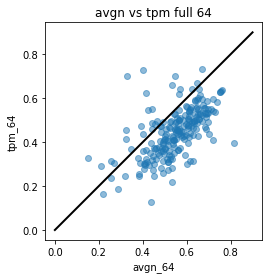

In [13]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(corrs_full_avgn, corrs_full_tpm, alpha=0.5)        ##change
plt.plot([0, 0.9], [0, 0.9], color = 'black', linewidth = 2)
ax.set_aspect('equal', adjustable='box')
plt.title('avgn vs tpm full {}'.format(d))                      ##change
plt.xlabel('avgn_{}'.format(d))
plt.ylabel('tpm_{}'.format(d))                                  ##change
plt.show()

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 2, 3)
fig.suptitle('Horizontally stacked subplots')

ax1.scatter(corrs_full_avgn, corrs_full_tpm, alpha=0.5)
ax1.plot([0, 0.9], [0, 0.9], color = 'black', linewidth = 2)
ax1.set_aspect('equal', adjustable='box')
ax1.title('avgn vs tpm full {}'.format(d))

ax2.scatter(corrs_full_avgn, corrs_full_tpm, alpha=0.5)
ax2.plot([0, 0.9], [0, 0.9], color = 'black', linewidth = 2)
ax2.set_aspect('equal', adjustable='box')
ax2.title('avgn vs tpm full {}'.format(d))

In [ ]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(corrs_full_avgn, corrs_full_tcm, alpha=0.5)
plt.plot([0, 0.9], [0, 0.9], color = 'black', linewidth = 2)
ax.set_aspect('equal', adjustable='box')
plt.title('avgn vs tcm full {}'.format(d))
plt.xlabel('avgn_{}'.format(d))
plt.ylabel('tcm_{}'.format(d))
plt.show()

In [ ]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(corrs_lin_avgn, corrs_lin_tpm, alpha=0.5)
plt.plot([0, 0.9], [0, 0.9], color = 'black', linewidth = 2)
ax.set_aspect('equal', adjustable='box')
plt.title('avgn vs tpm lin {}'.format(d))
plt.xlabel('avgn_{}'.format(d))
plt.ylabel('tpm_{}'.format(d))
plt.show()

In [ ]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(corrs_lin_avgn, corrs_lin_tcm, alpha=0.5)
plt.plot([0, 0.9], [0, 0.9], color = 'black', linewidth = 2)
ax.set_aspect('equal', adjustable='box')
plt.title('avgn vs tcm lin {}'.format(d))
plt.xlabel('avgn_{}'.format(d))
plt.ylabel('tcm_{}'.format(d))
plt.show()

In [ ]:
d=1024

In [ ]:
exp_path_avgn = '/mnt/cube/srrudrar/avgn_model/B1240/32x32/stim_resp_32x32_{}/test_set_mne/'.format(d)
exp_path_tpm = '/mnt/cube/srrudrar/temporal_model/B1240/32x32/stim_resp_32x32_{}/test_set_mne/'.format(d)
exp_path_tcm = '/mnt/cube/srrudrar/temporal_cnn_model/B1240/32x32/stim_resp_32x32_{}/test_set_mne/'.format(d)

MNE_test_dset_avgn = '/mnt/cube/srrudrar/avgn_model/B1240/32x32/stim_resp_32x32_{}/test_set_mne/MNE_test_dset/'.format(d)
MNE_test_dset_tpm = '/mnt/cube/srrudrar/temporal_model/B1240/32x32/stim_resp_32x32_{}/test_set_mne/MNE_test_dset/'.format(d) 
MNE_test_dset_tcm = '/mnt/cube/srrudrar/temporal_cnn_model/B1240/32x32/stim_resp_32x32_{}/test_set_mne/MNE_test_dset/'.format(d) 

In [ ]:
corrs_full_avgn = []
corrs_full_tpm = []
corrs_full_tcm = []
corrs_lin_avgn = []
corrs_lin_tpm = []
corrs_lin_tcm = []
units = []

for unit in clusters:
    ########################### avgn corr
    with open(os.path.join(MNE_test_dset_avgn, 'unit-{}_MNE.pkl'.format(unit)), 'rb') as f:       #change
        test_dict_avgn = pickle.load(f)
    stims_test_avgn = test_dict_avgn['stims_test']
    resps_test_avgn = test_dict_avgn['resps_test']
    
    with open(os.path.join(exp_path_avgn, 'all_1_2_3_MNEs_random_test.pkl'), 'rb') as f:       #change                        
        pfinals_avgn = pickle.load(f)
    pfinal_avgn = pfinals_avgn[unit]
    
    probs_avgn, corr_avgn = evaluate_prediction(pfinal_avgn, stims_test_avgn, resps_test_avgn, sdim=d)
    probs_lin_avgn, corr_lin_avgn = evaluate_pred_lin(pfinal_avgn, stims_test_avgn, resps_test_avgn, sdim=d)
    
    
    ################################ tpm corr
    with open(os.path.join(MNE_test_dset_tpm, 'unit-{}_MNE.pkl'.format(unit)), 'rb') as f:       #change
        test_dict_tpm = pickle.load(f)
    stims_test_tpm = test_dict_tpm['stims_test']
    resps_test_tpm = test_dict_tpm['resps_test']
    
    with open(os.path.join(exp_path_tpm, 'all_1_2_3_MNEs_random_test.pkl'), 'rb') as f:       #change                        
        pfinals_tpm = pickle.load(f)
    pfinal_tpm = pfinals_tpm[unit]
    
    probs_tpm, corr_tpm = evaluate_prediction(pfinal_tpm, stims_test_tpm, resps_test_tpm, sdim=d)
    probs_lin_tpm, corr_lin_tpm = evaluate_pred_lin(pfinal_tpm, stims_test_tpm, resps_test_tpm, sdim=d)
    
    
    ################################# tcm corr
    with open(os.path.join(MNE_test_dset_tcm, 'unit-{}_MNE.pkl'.format(unit)), 'rb') as f:       #change
        test_dict_tcm = pickle.load(f)
    stims_test_tcm = test_dict_tcm['stims_test']
    resps_test_tcm = test_dict_tcm['resps_test']
    
    with open(os.path.join(exp_path_tcm, 'all_1_2_3_MNEs_random_test.pkl'), 'rb') as f:       #change                        
        pfinals_tcm = pickle.load(f)
    pfinal_tcm = pfinals_tcm[unit]
    
    probs_tcm, corr_tcm = evaluate_prediction(pfinal_tcm, stims_test_tcm, resps_test_tcm, sdim=d)
    probs_lin_tcm, corr_lin_tcm = evaluate_pred_lin(pfinal_tcm, stims_test_tcm, resps_test_tcm, sdim=d)
    
    
    ################################ form lists of correlations
    corrs_full_avgn.append(corr_avgn[0])
    corrs_lin_avgn.append(corr_lin_avgn[0])
    corrs_full_tpm.append(corr_tpm[0])
    corrs_lin_tpm.append(corr_lin_tpm[0])
    corrs_full_tcm.append(corr_tcm[0])
    corrs_lin_tcm.append(corr_lin_tcm[0])
    units.append(unit)

In [ ]:
np.save('/mnt/cube/srrudrar/corrs/B1240/tcm_32x32/tcm_1024_full.npy', corrs_full_tcm)
np.save('/mnt/cube/srrudrar/corrs/B1240/tcm_32x32/tcm_1024_lin.npy', corrs_lin_tcm)

np.save('/mnt/cube/srrudrar/corrs/B1240/tpm_32x32/tpm_1024_full.npy', corrs_full_tpm)
np.save('/mnt/cube/srrudrar/corrs/B1240/tpm_32x32/tpm_1024_lin.npy', corrs_lin_tpm)

np.save('/mnt/cube/srrudrar/corrs/B1240/avgn_32x32/avgn_1024_full.npy', corrs_full_avgn)
np.save('/mnt/cube/srrudrar/corrs/B1240/avgn_32x32/avgn_1024_lin.npy', corrs_lin_avgn)

In [ ]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(corrs_full_avgn, corrs_full_tpm, alpha=0.5)
plt.plot([0, 0.9], [0, 0.9], color = 'black', linewidth = 2)
ax.set_aspect('equal', adjustable='box')
plt.title('avgn vs tpm full {}'.format(d))
plt.xlabel('avgn_{}'.format(d))
plt.ylabel('tpm_{}'.format(d))
plt.show()

In [ ]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(corrs_full_avgn, corrs_full_tcm, alpha=0.5)
plt.plot([0, 0.9], [0, 0.9], color = 'black', linewidth = 2)
ax.set_aspect('equal', adjustable='box')
plt.title('avgn vs tcm full {}'.format(d))
plt.xlabel('avgn_{}'.format(d))
plt.ylabel('tcm_{}'.format(d))
plt.show()

In [ ]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(corrs_lin_avgn, corrs_lin_tpm, alpha=0.5)
plt.plot([0, 0.9], [0, 0.9], color = 'black', linewidth = 2)
ax.set_aspect('equal', adjustable='box')
plt.title('avgn vs tpm lin {}'.format(d))
plt.xlabel('avgn_{}'.format(d))
plt.ylabel('tpm_{}'.format(d))
plt.show()

In [ ]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(corrs_lin_avgn, corrs_lin_tcm, alpha=0.5)
plt.plot([0, 0.9], [0, 0.9], color = 'black', linewidth = 2)
ax.set_aspect('equal', adjustable='box')
plt.title('avgn vs tcm lin {}'.format(d))
plt.xlabel('avgn_{}'.format(d))
plt.ylabel('tcm_{}'.format(d))
plt.show()